In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import featuretools as ft
%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='featuretools.computational_backends.feature_set_calculator')

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [ ]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1']]

# Pos_Cash Balance
Pos_Cash Balance describes monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans.
* These is ~10 mill. observations and 8 features, no duplicates. Null values for CNT_INSTALMENT and CNT_INSTALMENT_FUTURE seam to be related.

In [2]:
pos_cash = help_tool.csv_download(r'Archive\home-credit-default-risk\POS_CASH_balance.csv')
help_tool.first_look(pos_cash)

Dataset has 10001358 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


dtypes Null values, Count Null values, %
SK_ID_PREV               int64                  0            0.0
SK_ID_CURR               int64                  0            0.0
MONTHS_BALANCE           int64                  0            0.0
CNT_INSTALMENT         float64              26071            0.3
CNT_INSTALMENT_FUTURE  float64              26087            0.3
NAME_CONTRACT_STATUS    object                  0            0.0
SK_DPD                   int64                  0            0.0
SK_DPD_DEF               int64                  0            0.0

## Null values

When CNT_INSTALMENT is misisng, SK_DPD and SK_DPD_DEF have values 0

In [3]:
pos_cash[pos_cash['CNT_INSTALMENT'].isna() & pos_cash['CNT_INSTALMENT_FUTURE'].isna()][['SK_DPD', 'SK_DPD_DEF']].value_counts()

SK_DPD  SK_DPD_DEF
0       0             25974
Name: count, dtype: int64

Null values will be dropped

In [3]:
pos_cash = pos_cash[pos_cash['CNT_INSTALMENT'].notna() & pos_cash['CNT_INSTALMENT_FUTURE'].notna()]

## EDA
### Numerical Features

MONTHS_BALANCE


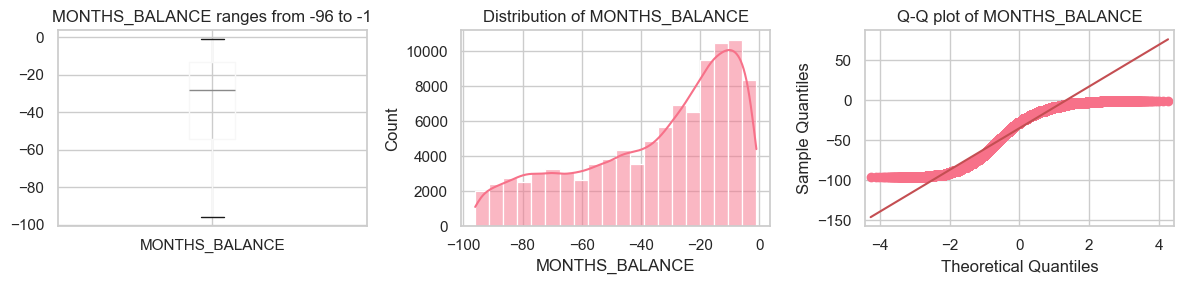

CNT_INSTALMENT


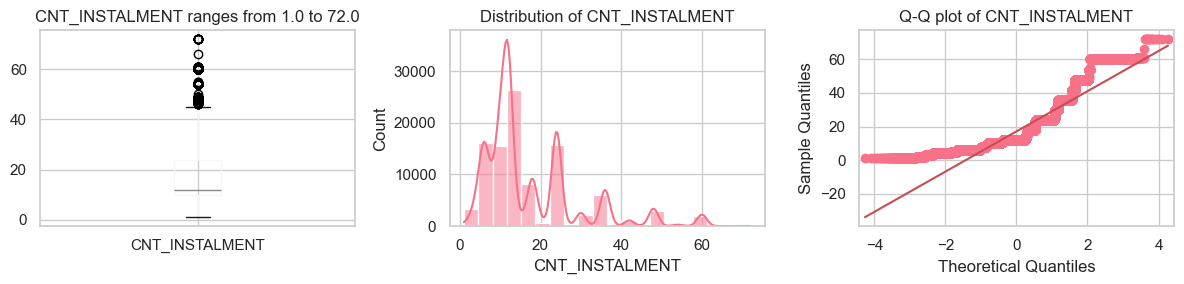

CNT_INSTALMENT_FUTURE


SK_DPD


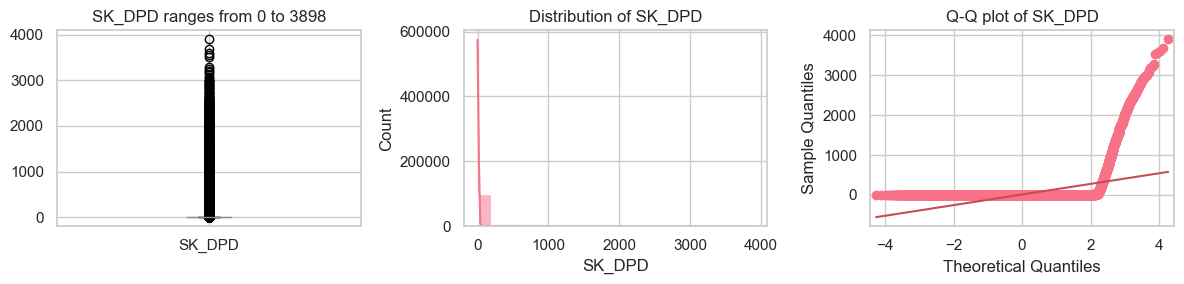

SK_DPD_DEF


In [5]:
help_visuals.distribution_check(pos_cash.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).sample(100000, random_state=42))

### Categorical Features
Since dataset has only 1 categorical features, let's examine it through account activity via Instalments and Days Past Due (DPD)
#### Instalments
CNT_INSTALMENT_FUTURE and CNT_INSTALMENT_FUTURE have a dependency between each other, which is described by NAME_CONTRACT_STATUS

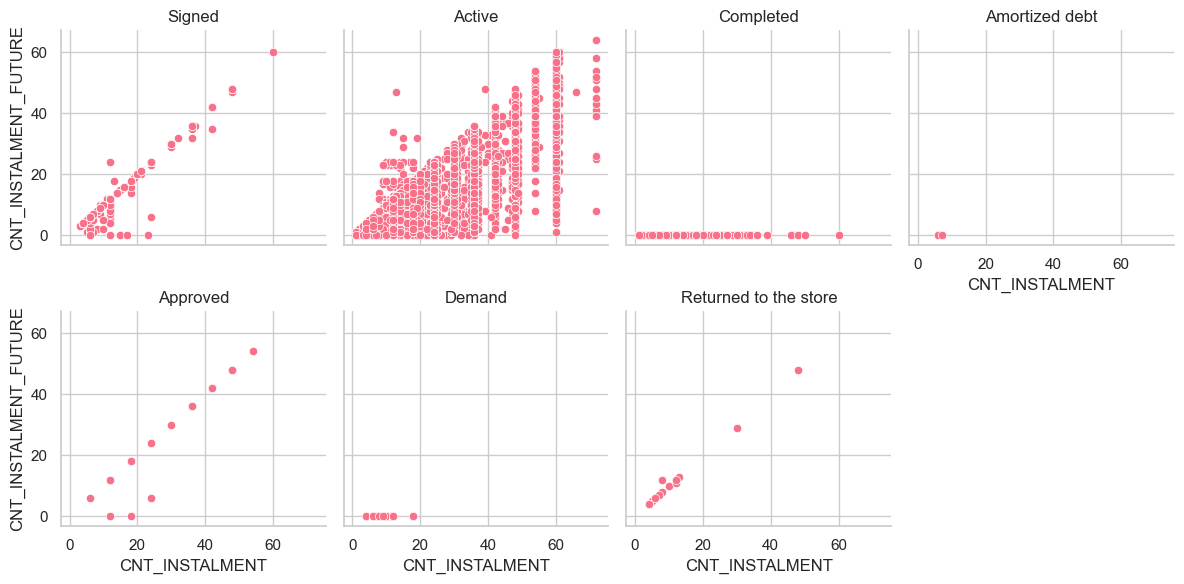

In [6]:
g = sns.FacetGrid(pos_cash.sample(100000, random_state=42), col="NAME_CONTRACT_STATUS", col_wrap=4)
g.map(sns.scatterplot, "CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.show()

Ratio between SK_DPD and SK_DPD_DEF is not a constant when Status is Demand or Amortized debt. Which could sugest Ratio is depicting bad customers.

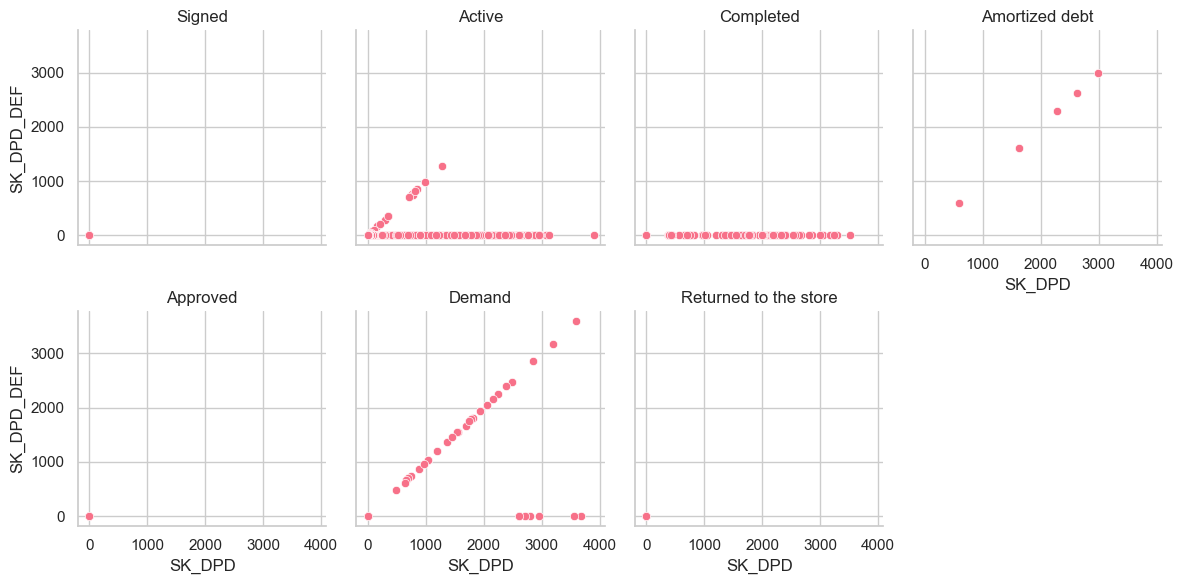

In [7]:
g = sns.FacetGrid(pos_cash.sample(100000, random_state=42), col="NAME_CONTRACT_STATUS", col_wrap=4)
g.map(sns.scatterplot, "SK_DPD", "SK_DPD_DEF")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.show()

As seen in the above graghs, NAME_CONTRACT_STATUS determines balance expectations and behaviour. Thus, it can be separated into 2 columns for card activity and risk profile

In [4]:
# Apply the functions to create new columns
pos_cash['CARD_ACTIVITY'] = pos_cash['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_card_activity)
pos_cash['RISK_PROFILE'] = pos_cash['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_risk_profile)

pos_cash.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)

## Feature engineering
FeatureTools will be used for aggregation, but it can't depict ratios on sertain important parameters - instalement payed vs not yet payed, missing payments on small vs large loans.

In [5]:
pos_cash[['RATIO_Term_Payed_Left', 'RATIO_DPD']] = duckdb.query("""
             SELECT 
             (CNT_INSTALMENT / CNT_INSTALMENT_FUTURE) AS RATIO_Term_Payed_Left,
             (SK_DPD / SK_DPD_DEF) AS RATIO_DPD
             FROM pos_cash
""").to_df()

### Aggregated features with FeatureTools
FeatureTools will aggregate features to sum, mean, man, mix, etc. This is done as it's imposible to guess which of the aggregates will be most useful to model predictions. Instead of guessing, all created features will be applied to Light XGB and filtered based on feature importance.

In [6]:
pos_cash_feature_matrix = help_model.aggregated_features(pos_cash.drop(columns=['MONTHS_BALANCE']), 'SK_ID_PREV')
pos_cash_feature_matrix.shape

KeyboardInterrupt: 

In [ ]:
# Adding features with more dificult math

pos_cash_feature_matrix = duckdb.query("""  
  SELECT A.*, B.Duration
  FROM pos_cash_feature_matrix A 
  LEFT JOIN (
    SELECT SK_ID_PREV, MAX(MONTHS_BALANCE) - MIN(MONTHS_BALANCE) AS Duration
    FROM pos_cash
    GROUP BY SK_ID_PREV
    ) B ON A.SK_ID_PREV = B.SK_ID_PREV
  """).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Exporting new aggregated features as a check-point

In [2]:
#pos_cash_feature_matrix.to_csv(r'Archive\home-credit-default-risk\pos_cash_feature_matrix.csv')
#pos_cash_feature_matrix = help_tool.csv_download(r'Archive\home-credit-default-risk\pos_cash_feature_matrix.csv').drop(columns='Unnamed: 0')

## Selecting features
### Target

Only 7% of target is positive

In [17]:
app_pos_cash_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET, B.EXT_SOURCE_1
    FROM pos_cash_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

app_pos_cash_feature_matrix['TARGET'].value_counts() / app_pos_cash_feature_matrix['TARGET'].count() * 100

TARGET
0    92.630599
1     7.369401
Name: count, dtype: float64

In [22]:
app_pos_cash_feature_matrix['EXT_SOURCE_1'].isna().sum()

449436

56% of all EXT_SOURCE_1 values are missing

In [24]:
app_pos_cash_feature_matrix['EXT_SOURCE_1'].isna().sum() / (app_pos_cash_feature_matrix['EXT_SOURCE_1'].notna().sum() + app_pos_cash_feature_matrix['EXT_SOURCE_1'].isna().sum())

0.5621020482438532

#### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

In [26]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_pos_cash_feature_matrix.fillna(-1), app_pos_cash_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1']).columns.to_list(), ['TARGET'])

#### Light XGB
High model evaluation metrics are not then goal for feature selection. However, accuracy and recall indicates model preferring only the dominat class (accuracy would reflect the 92% - 7% distribution). 

In this case, Light XGB uses class weights and should have somewhat of a balanced preference to classes. 

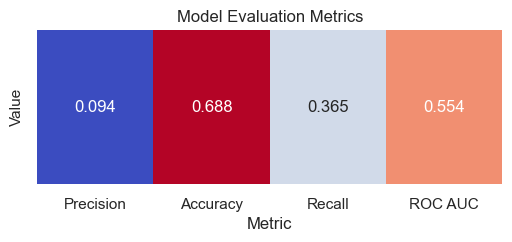

In [19]:
pos_cash_feature_importance = help_model.model_feature_importance_target(app_pos_cash_feature_matrix)

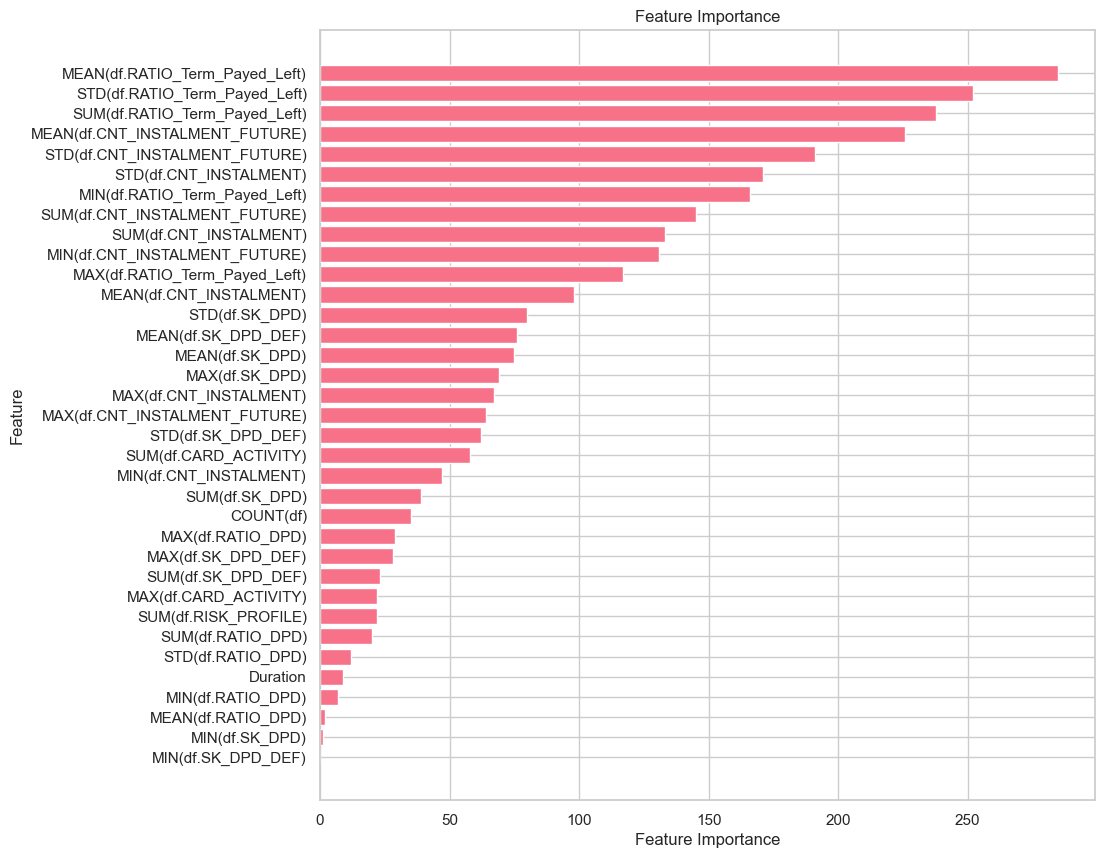

In [22]:
help_model.plot_feature_importance(pos_cash_feature_importance)

#### 6 top features are selected
Pearson correlation shows 'STD(pos_cash.RATIO_Term_Payed_Left)' and 'MEAN(pos_cash.RATIO_Term_Payed_Left)' are linearly correlated

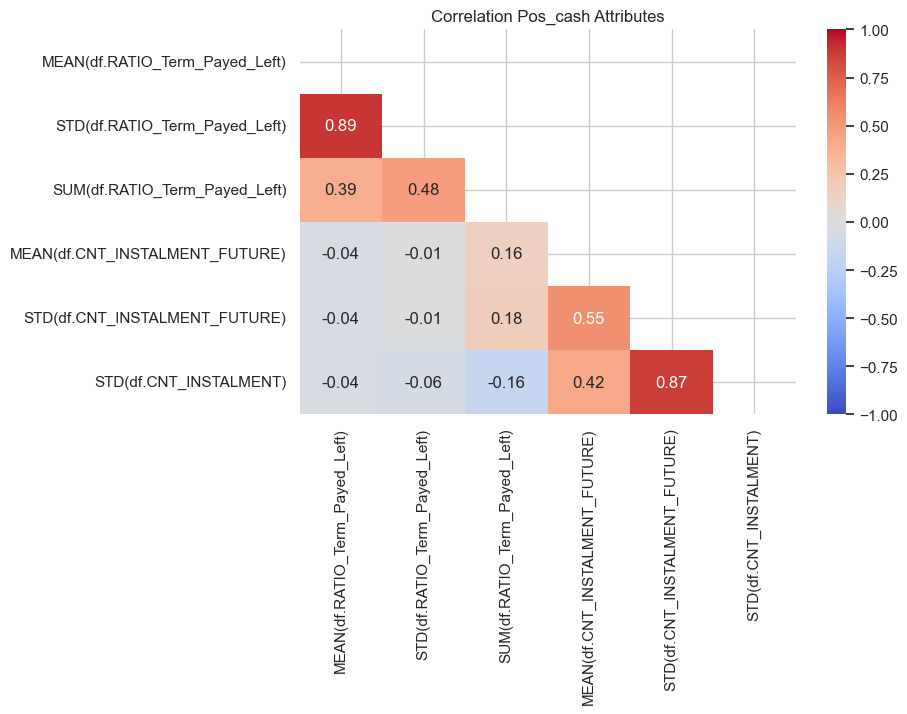

In [23]:
help_visuals.heatmap(app_pos_cash_feature_matrix[pos_cash_feature_importance['feature'].head(6).to_list()], 'pos_cash', 'pearson')

In [24]:
sns.pairplot(app_pos_cash_feature_matrix[pos_cash_feature_importance['feature'].head(6).to_list() + ['TARGET']].sample(100000, random_state=42), hue='TARGET', corner=True)
plt.show()

#### Multicollinearity

Multicollinearity can occur in regression analysis when two or more predictor variables are highly correlated to each other. this way they do not provide unique/independent information in the regression model.

Variance Inflation Factor (VIF) = 1/ (1-R^2)

R^2 - coefficient of determination

* VIF = 1, no correlation between the independent variable and the other variables
* VIF above 5 or 10 indicates high Multicollinearity between this independent variable and the others

Variance Inflation Factor (VIF) is specifically designed to detect Multicollinearity. VIF quantifies the severity of Multicollinearity in an ordinary least squares regression analysis. It's calculated by assessing how much the variance of a regression coefficient is inflated due to Multicollinearity in the model.

In [25]:
help_stats.vif(app_pos_cash_feature_matrix[pos_cash_feature_importance['feature'].head(6).to_list()].fillna(-1))

variables        VIF
0  MEAN(df.RATIO_Term_Payed_Left)   8.269377
1   STD(df.RATIO_Term_Payed_Left)   6.649004
2   SUM(df.RATIO_Term_Payed_Left)   6.842597
3  MEAN(df.CNT_INSTALMENT_FUTURE)   2.792394
4   STD(df.CNT_INSTALMENT_FUTURE)  15.969397
5          STD(df.CNT_INSTALMENT)   7.017522

VIF having similar values (15 and 16) signals multicollinearity pair. MEAN(pos_cash.RATIO_Term_Payed_Left) is also strongly linearly correlated (0.89) with STD(pos_cash.RATIO_Term_Payed_Left), only the higher in feature importance will be left in.

#### Removing Multicollinear Features in K-means Clustering
Multicollinear features provide redundant information, which can distort the distance calculations that K-means relies on. Also, interpretation of clusters are more straightforward, as each feature contributes unique information.

In [49]:
pos_cash_selected_features = ['STD(df.RATIO_Term_Payed_Left)', 'MEAN(df.CNT_INSTALMENT_FUTURE)', 'SUM(df.RATIO_Term_Payed_Left)', 'STD(df.CNT_INSTALMENT)']

STD(df.RATIO_Term_Payed_Left)


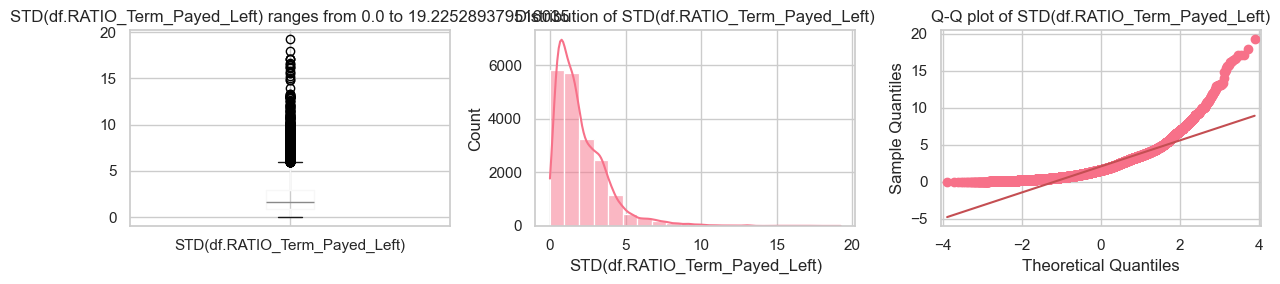

MEAN(df.CNT_INSTALMENT_FUTURE)


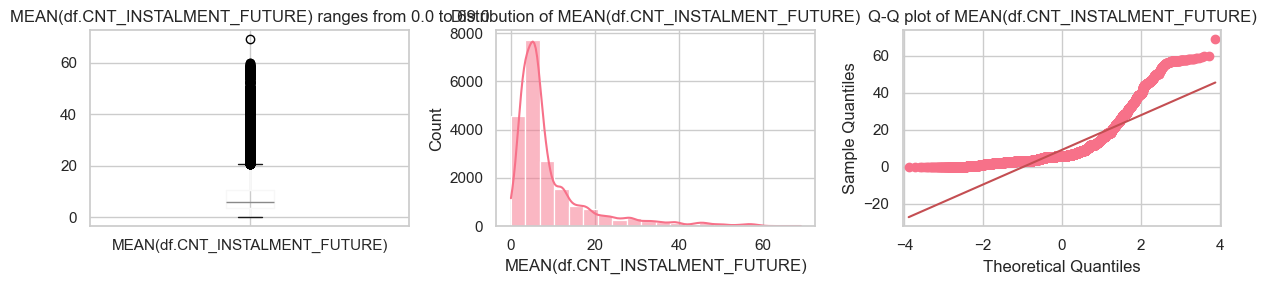

SUM(df.RATIO_Term_Payed_Left)


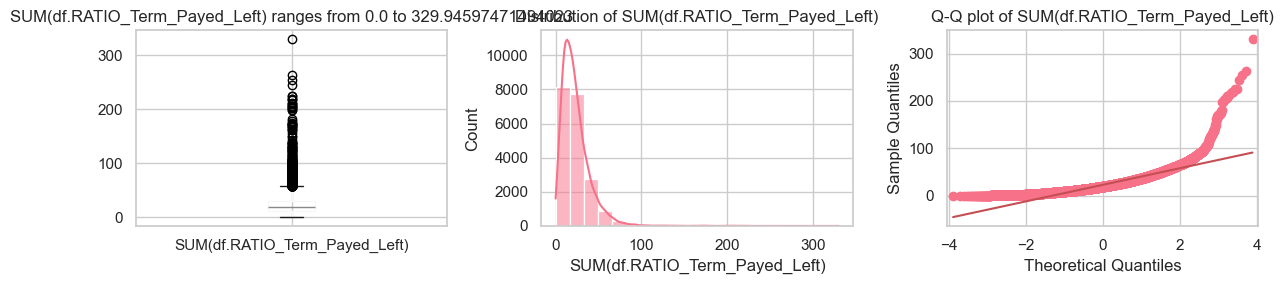

STD(df.CNT_INSTALMENT)


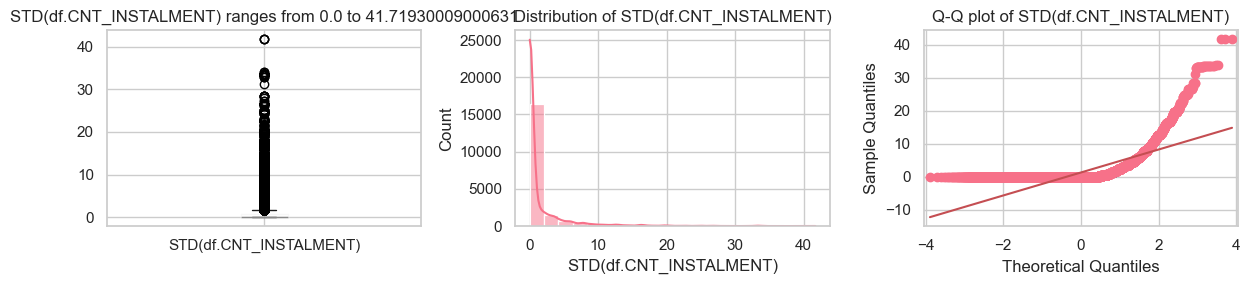

In [27]:
help_visuals.distribution_check(app_pos_cash_feature_matrix[pos_cash_selected_features].sample(20000, random_state=42))

#### Clustering with K means

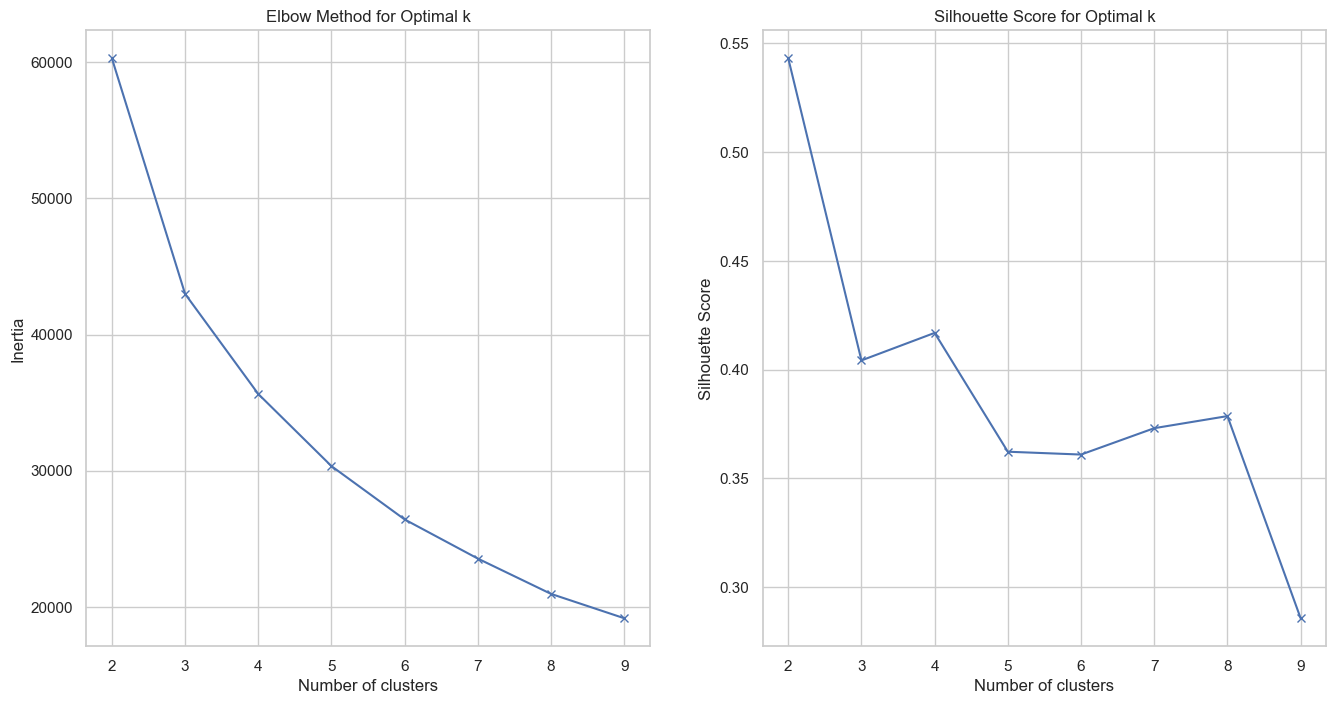

In [28]:
help_model.clustering_k_means_test(pos_cash_feature_matrix[pos_cash_selected_features].sample(20000, random_state=42).fillna(0))

* Cluster 0: Customers with a low number of instalments.
* Cluster 1: Customers with high number of instalments.
* Cluster 2: Customers with high number of instalments and have repayed them.<br>
Cluster 1 can be categorized as high risk for deafault, while Clusters 0 and 2 show either small instalment count or customer proved being able to repay.

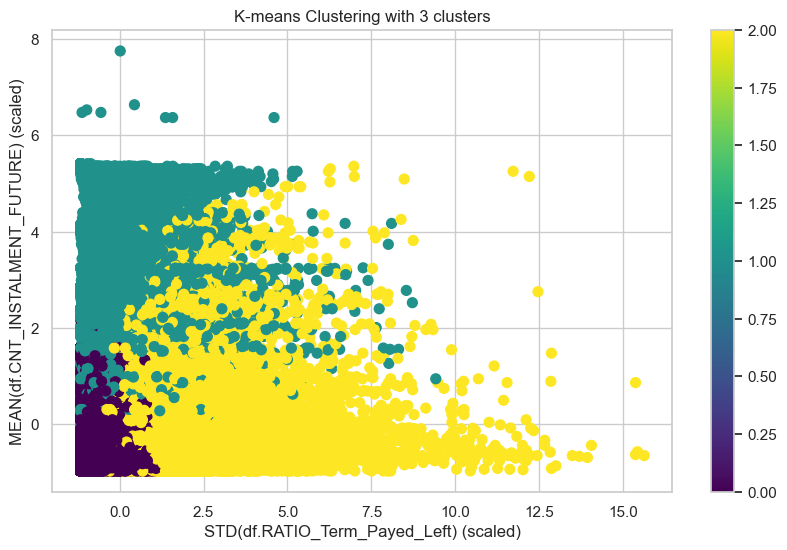

In [54]:
pos_cash_feature_matrix['Cluster_pos_cash'] = help_model.clustering_k_means(pos_cash_feature_matrix[pos_cash_selected_features].fillna(0), 3)

In [4]:
sorted_pos_cash_feature_matrix = help_tool.csv_download(r'Archive\home-credit-default-risk\sorted_pos_cash_feature_matrix.csv').drop(columns='Unnamed: 0')

### EXT_SOURCE_1
#### Pearson correlation
Pearson correlation also shows no correlation between created features and EXT_SOURCE_1.

In [37]:
plt.figure(figsize=(20, 6))
help_stats.pearson_heatmap(app_pos_cash_feature_matrix.dropna(subset='EXT_SOURCE_1').fillna(0), app_pos_cash_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1']).columns.to_list(), 'EXT_SOURCE_1')

In [46]:
pos_cash_feature_importance = help_model.model_feature_importance_exteranal(app_pos_cash_feature_matrix)

EXT_SOURCE_1 has these top features:

In [51]:
pos_cash_feature_importance.head(5)

feature  importance
23   STD(df.RATIO_Term_Payed_Left)         270
11  MEAN(df.RATIO_Term_Payed_Left)         247
9   MEAN(df.CNT_INSTALMENT_FUTURE)         232
30   SUM(df.RATIO_Term_Payed_Left)         204
2           MAX(df.CNT_INSTALMENT)         167

Comparing with previously generated feature importance of LGBMClassifier, it is seen that they are the same.

In [50]:
pos_cash_selected_features

['STD(df.RATIO_Term_Payed_Left)',
 'MEAN(df.CNT_INSTALMENT_FUTURE)',
 'SUM(df.RATIO_Term_Payed_Left)',
 'STD(df.CNT_INSTALMENT)']

### Conclusion
Created groups should accomodate both Target and EXT_SOURCE_1. This probably due to EXT_SOURCE_1 and Target depicting the same probability of default. No further reaseach will be done on next daysets.

## Exporting grouped dataset

In [52]:
pos_cash_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET, B.EXT_SOURCE_1
    FROM pos_cash_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

Two Clusters have the same 7% of class 1 ('TARGET'), but third has 10%. This could be beneficial for model construction.

In [55]:
pos_cash_feature_matrix[['Cluster_pos_cash', 'TARGET']].value_counts().sort_index() / pos_cash_feature_matrix['Cluster_pos_cash'].value_counts().sort_index() * 100

Cluster_pos_cash  TARGET
0                 0         92.950206
                  1          7.049794
1                 0         89.823935
                  1         10.176065
2                 0         92.809596
                  1          7.190404
Name: count, dtype: float64

In [36]:
sorted_pos_cash_feature_matrix = pos_cash_feature_matrix[['SK_ID_PREV', 'SK_ID_CURR', 'Cluster_pos_cash'] + pos_cash_selected_features]
sorted_pos_cash_feature_matrix.to_csv(r'Archive\home-credit-default-risk\sorted_pos_cash_feature_matrix.csv')

# Installments Payments

In [37]:
installments_payments = help_tool.csv_download(r'Archive\home-credit-default-risk\installments_payments.csv')
help_tool.first_look(installments_payments)

Dataset has 13605401 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


dtypes Null values, Count Null values, %
SK_ID_PREV                int64                  0            0.0
SK_ID_CURR                int64                  0            0.0
NUM_INSTALMENT_VERSION  float64                  0            0.0
NUM_INSTALMENT_NUMBER     int64                  0            0.0
DAYS_INSTALMENT         float64                  0            0.0
DAYS_ENTRY_PAYMENT      float64               2905            0.0
AMT_INSTALMENT          float64                  0            0.0
AMT_PAYMENT             float64               2905            0.0

## Null values
Null values take less than 0%, 2905 rows. Payment day (DAYS_ENTRY_PAYMENT) is missing when payment amount is missing.

In [38]:
installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull() & installments_payments['AMT_PAYMENT'].notna()].shape

(0, 8)

Missing values are safe to drop, as the SK_ID_CURR can be found in non missing rows.

In [39]:
duckdb.query("""
             WITH 
             empty AS (
             SELECT DISTINCT SK_ID_CURR FROM installments_payments
             WHERE DAYS_ENTRY_PAYMENT IS NULL
             )

             ,not_empty AS (
             SELECT DISTINCT SK_ID_CURR FROM installments_payments
             WHERE DAYS_ENTRY_PAYMENT IS NOT NULL
             )

             SELECT *
             FROM empty
             LEFT JOIN not_empty
             ON empty.SK_ID_CURR = not_empty.SK_ID_CURR
             WHERE empty.SK_ID_CURR IS NULL
             """).to_df().shape

(0, 2)

In [40]:
installments_payments = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].notna() & installments_payments['AMT_PAYMENT'].notna()]

## EDA
### Numerical Features

NUM_INSTALMENT_VERSION


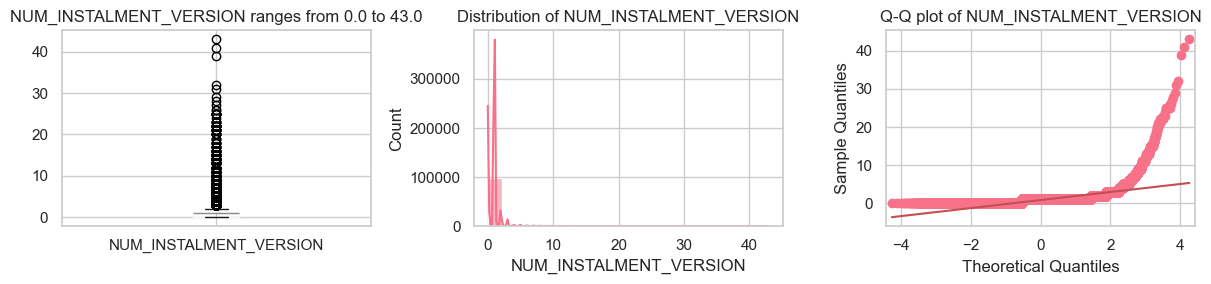

NUM_INSTALMENT_NUMBER


DAYS_INSTALMENT


DAYS_ENTRY_PAYMENT


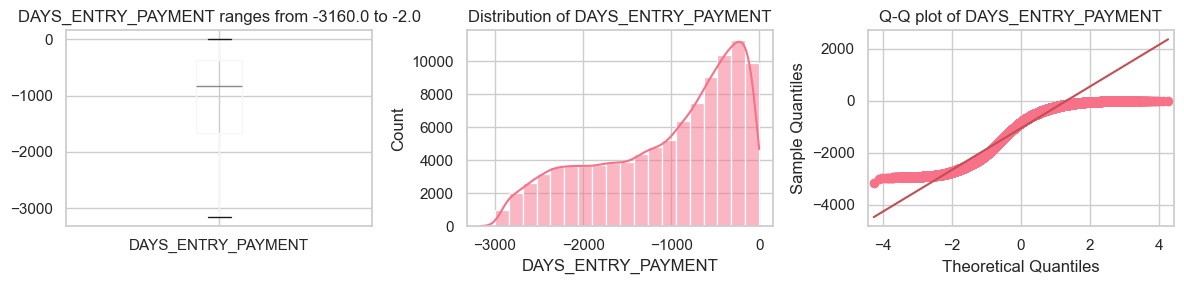

AMT_INSTALMENT


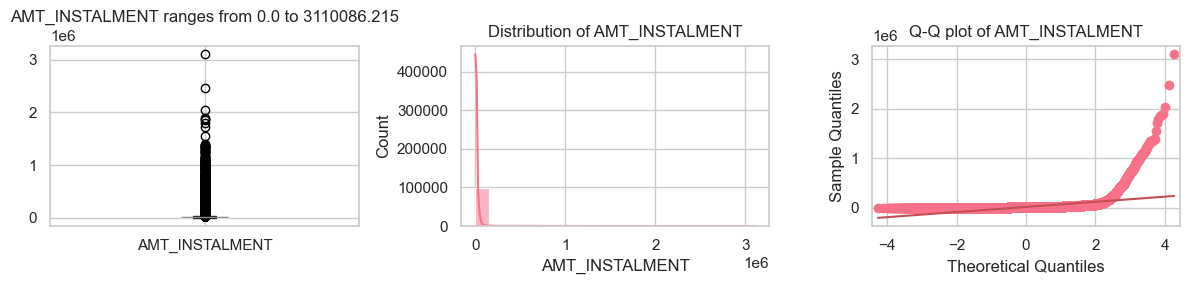

AMT_PAYMENT


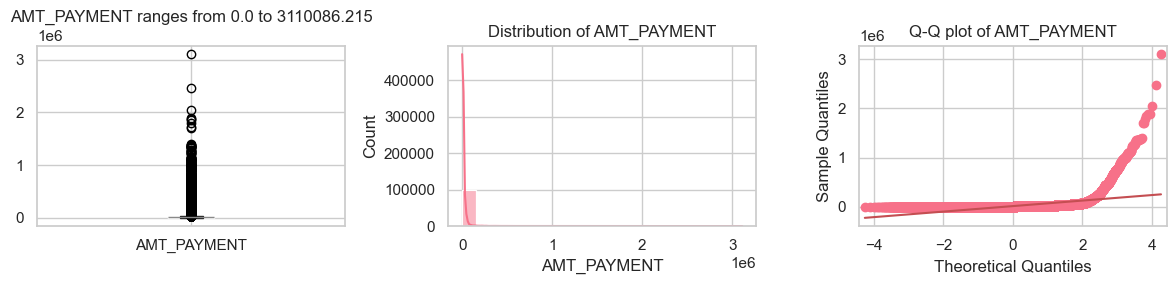

In [41]:
help_visuals.distribution_check(installments_payments.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).sample(100000, random_state=42))

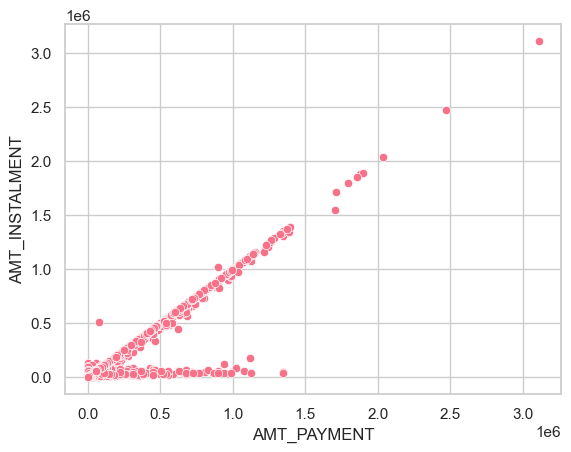

In [42]:
sns.scatterplot(data=installments_payments.sample(100000, random_state=42), x='AMT_PAYMENT', y='AMT_INSTALMENT')
plt.show()

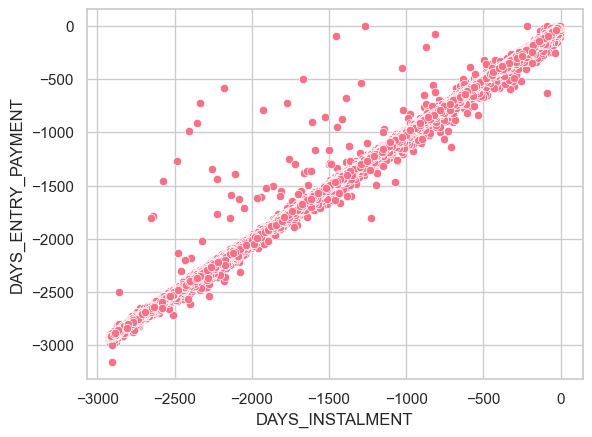

In [43]:
sns.scatterplot(data=installments_payments.sample(100000, random_state=42), x='DAYS_INSTALMENT', y='DAYS_ENTRY_PAYMENT')
plt.show()

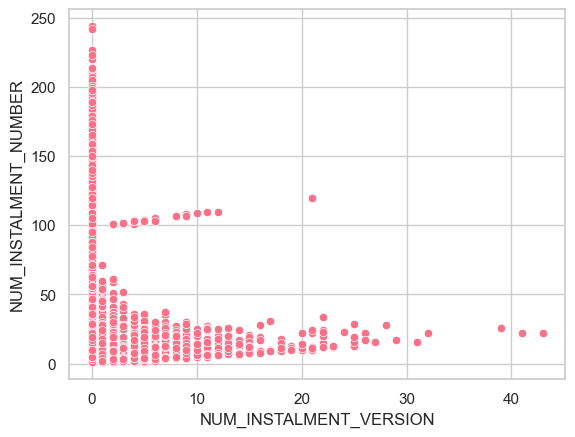

In [44]:
sns.scatterplot(data=installments_payments.sample(100000, random_state=42), x='NUM_INSTALMENT_VERSION', y='NUM_INSTALMENT_NUMBER')
plt.show()

## Feature Engineering
Adding features like missed deadline, missed payment and instalment number difference.

In [45]:
installments_payments[['MISSED_DEADLINE_DAYS', 'MISSED_AMT_PAYMENT', 'CHANGE_INSTALMENT_NUMBER']] = duckdb.query("""
        SELECT 
            CAST((CAST(DAYS_ENTRY_PAYMENT AS INT) - CAST(DAYS_INSTALMENT AS INT)) AS INT) AS MISSED_DEADLINE_DAYS,
            CAST((CAST(AMT_PAYMENT AS INT) - CAST(AMT_INSTALMENT AS INT)) AS INT) AS MISSED_AMT_PAYMENT,
            CAST((CAST(NUM_INSTALMENT_VERSION AS INT) - CAST(NUM_INSTALMENT_NUMBER AS INT)) AS INT) AS CHANGE_INSTALMENT_NUMBER                                                                                  
        FROM installments_payments 
""").to_df()

### Aggregated features with FeatureTools

In [46]:
installments_payments_feature_matrix = help_model.aggregated_features(installments_payments.drop(columns=['DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT']), 'SK_ID_PREV')
installments_payments_feature_matrix.shape

(997674, 37)

Adding aggregated duration

In [47]:
installments_payments_feature_matrix = duckdb.query("""  
  SELECT A.*, B.Duration
  FROM installments_payments_feature_matrix A 
  LEFT JOIN (
    SELECT SK_ID_PREV, MAX(DAYS_INSTALMENT) - MIN(DAYS_INSTALMENT) AS Duration
    FROM installments_payments
    GROUP BY SK_ID_PREV
    ) B ON A.SK_ID_PREV = B.SK_ID_PREV
  """).to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [48]:
installments_payments_feature_matrix.to_csv(r'Archive\home-credit-default-risk\installments_payments_feature_matrix.csv')

## Selecting features
7% of target is positive

In [49]:
app_installments_payments_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM installments_payments_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()
app_installments_payments_feature_matrix['TARGET'].value_counts() / app_installments_payments_feature_matrix['TARGET'].count() * 100

TARGET
0    92.440447
1     7.559553
Name: count, dtype: float64

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

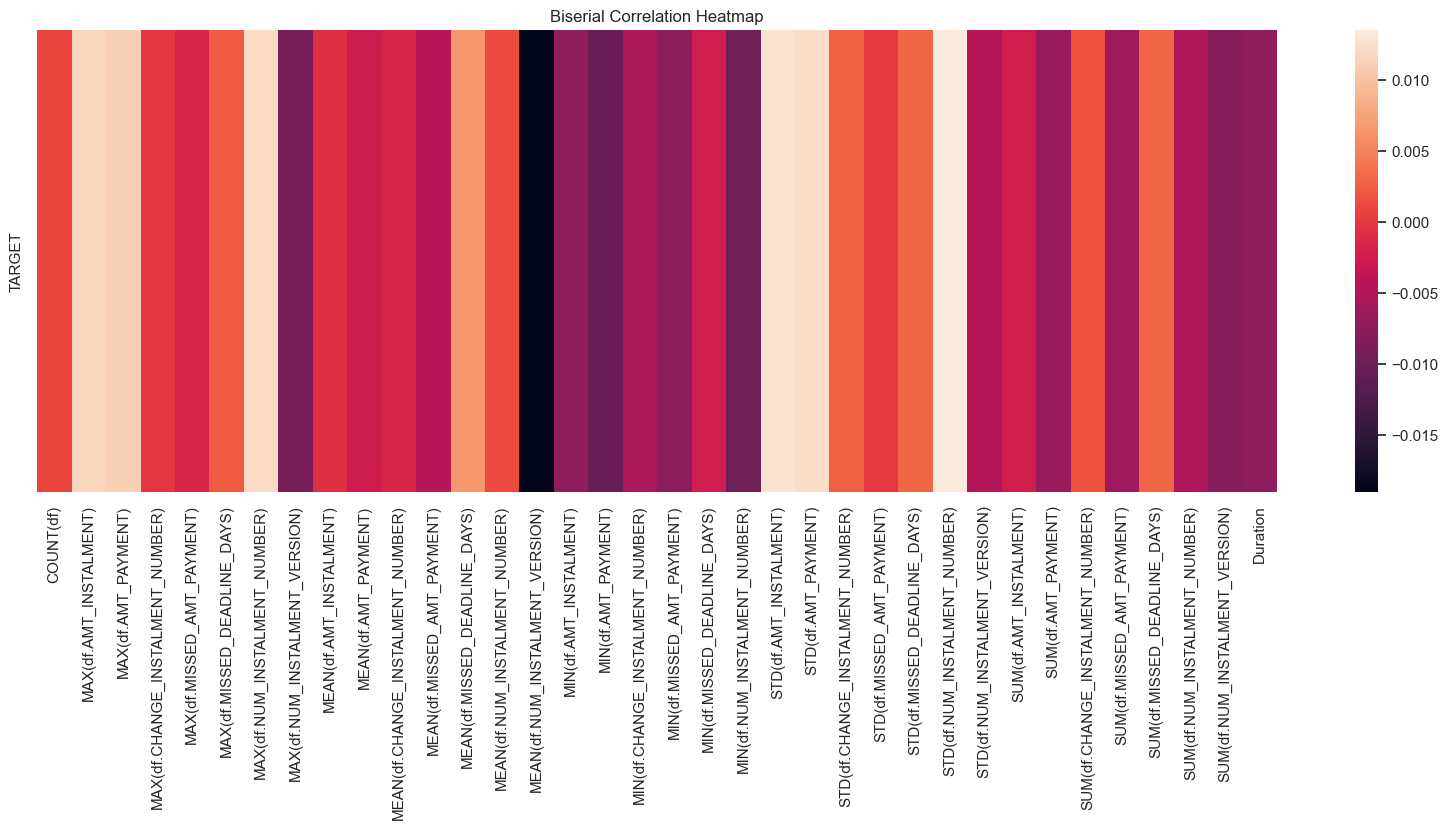

In [50]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_installments_payments_feature_matrix.fillna(-1), app_installments_payments_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

### Light XGB

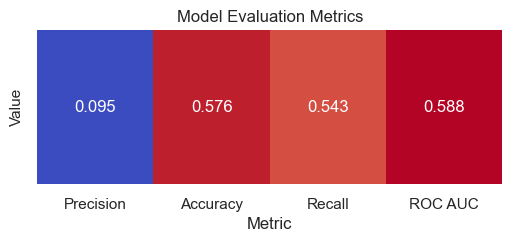

In [51]:
feature_importance_installments_payments = help_model.model_feature_importance_target(app_installments_payments_feature_matrix)

In [52]:
help_model.plot_feature_importance(feature_importance_installments_payments)

### 7 top features are selected
'STD(df.AMT_INSTALMENT)' is correlated with other 'AMT_INSTALMENT' features.

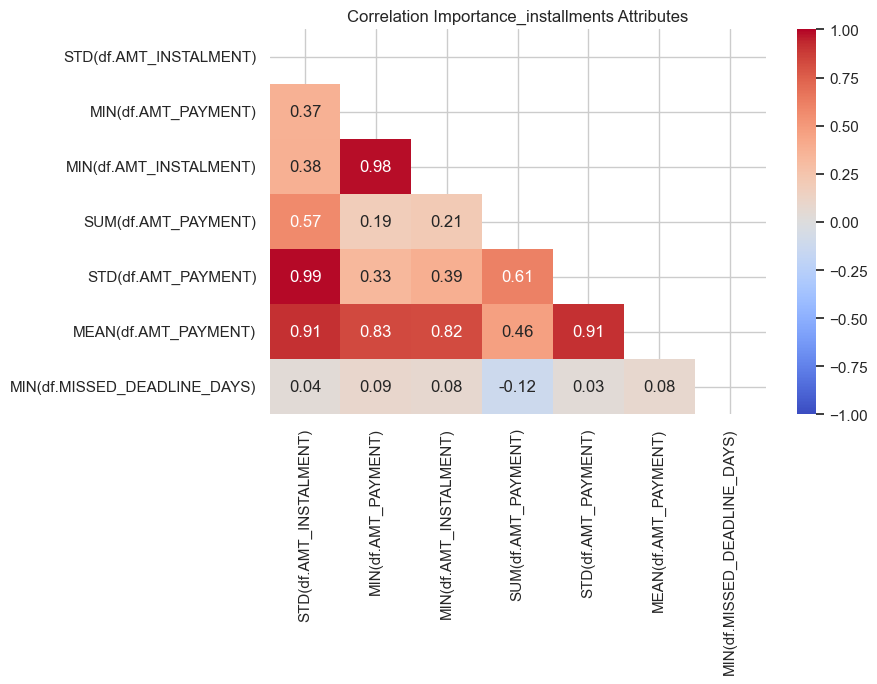

In [53]:
help_visuals.heatmap(app_installments_payments_feature_matrix[feature_importance_installments_payments['feature'].head(7).to_list()], 'importance_installments', 'pearson')

### Multicollinearity
No pair is above 5 in VIF, thus the selection is acceptable

In [54]:
installments_payments_selected_features = ['STD(df.AMT_INSTALMENT)', 'MIN(df.AMT_PAYMENT)', 'SUM(df.AMT_PAYMENT)']

In [55]:
help_stats.vif(app_installments_payments_feature_matrix[installments_payments_selected_features].fillna(-1))

variables       VIF
0  STD(df.AMT_INSTALMENT)  1.628769
1     MIN(df.AMT_PAYMENT)  1.094678
2     SUM(df.AMT_PAYMENT)  1.740067

STD(df.AMT_INSTALMENT)


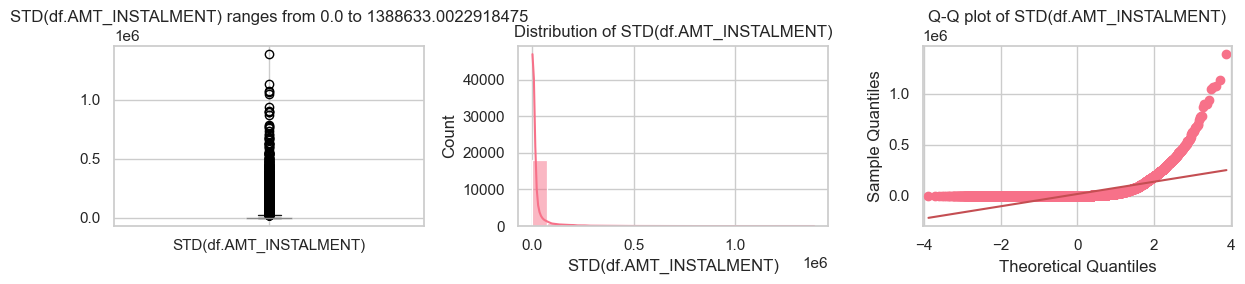

MIN(df.AMT_PAYMENT)


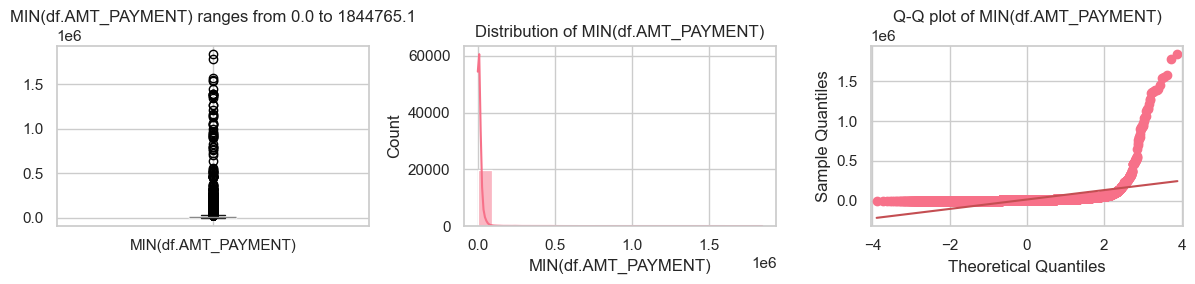

SUM(df.AMT_PAYMENT)


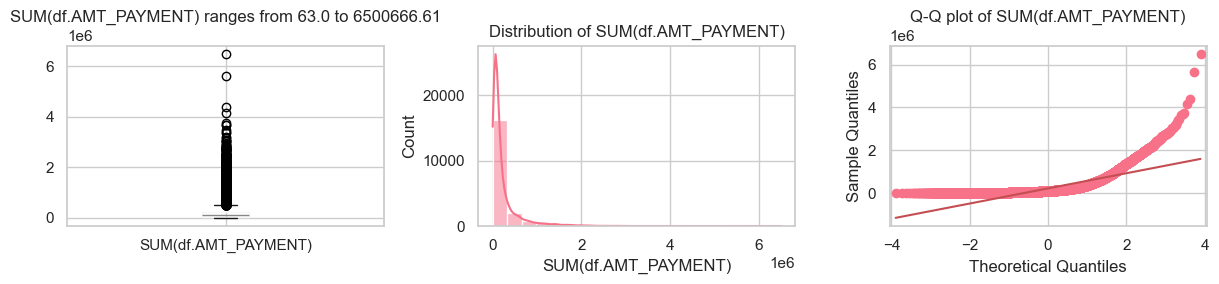

In [56]:
help_visuals.distribution_check(app_installments_payments_feature_matrix[installments_payments_selected_features].sample(20000, random_state=42))

## Clustering with K means

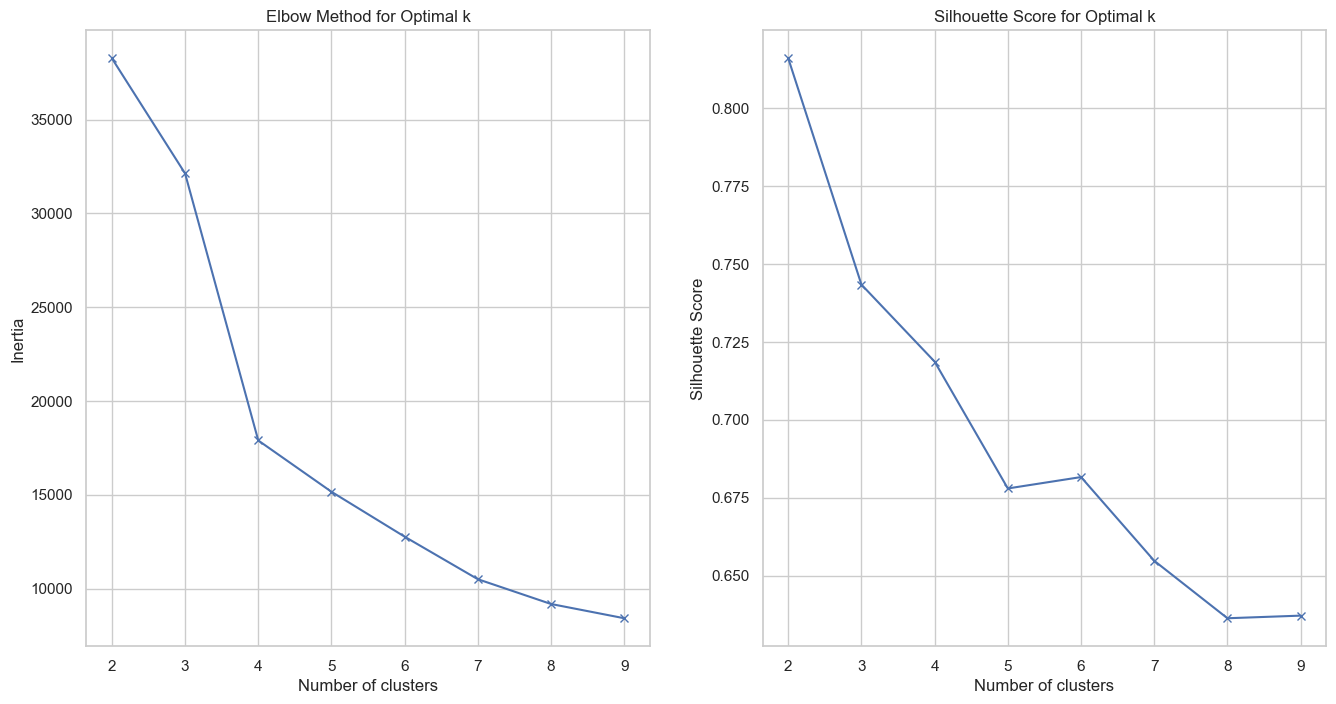

In [57]:
help_model.clustering_k_means_test(app_installments_payments_feature_matrix[installments_payments_selected_features].sample(20000, random_state=42).fillna(0))

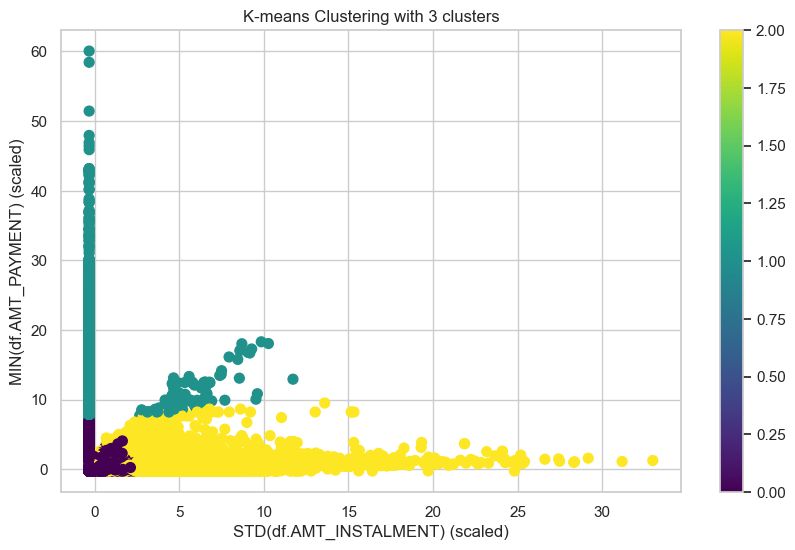

In [58]:
installments_payments_feature_matrix['Cluster_installments_payments'] = help_model.clustering_k_means(installments_payments_feature_matrix[installments_payments_selected_features].fillna(0), 3)

In [59]:
installments_payments_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM installments_payments_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

Clusters have similar distribution to TARGET and the whole dataset.

In [60]:
installments_payments_feature_matrix[['Cluster_installments_payments', 'TARGET']].value_counts().sort_index() / installments_payments_feature_matrix['Cluster_installments_payments'].value_counts().sort_index() * 100

Cluster_installments_payments  TARGET
0                              0         92.475932
                               1          7.524068
1                              0         92.544803
                               1          7.455197
2                              0         91.847344
                               1          8.152656
Name: count, dtype: float64

## Exporting grouped dataset

In [61]:
sorted_installments_payments_feature_matrix = installments_payments_feature_matrix[['SK_ID_PREV', 'SK_ID_CURR', 'Cluster_installments_payments'] + installments_payments_selected_features]
sorted_installments_payments_feature_matrix.to_csv(r'Archive\home-credit-default-risk\sorted_installments_payments_feature_matrix.csv')

# Credit_Card_Balance

In [62]:
credit_card_balance = help_tool.csv_download(r'Archive\home-credit-default-risk\credit_card_balance.csv')
help_tool.first_look(credit_card_balance)

Dataset has 3840312 observations and 23 features
Columns with all empty values []
Dataset has 0 duplicates


dtypes Null values, Count Null values, %
SK_ID_PREV                    int64                  0            0.0
SK_ID_CURR                    int64                  0            0.0
MONTHS_BALANCE                int64                  0            0.0
AMT_BALANCE                 float64                  0            0.0
AMT_CREDIT_LIMIT_ACTUAL       int64                  0            0.0
AMT_DRAWINGS_ATM_CURRENT    float64             749816           19.5
AMT_DRAWINGS_CURRENT        float64                  0            0.0
AMT_DRAWINGS_OTHER_CURRENT  float64             749816           19.5
AMT_DRAWINGS_POS_CURRENT    float64             749816           19.5
AMT_INST_MIN_REGULARITY     float64             305236            7.9
AMT_PAYMENT_CURRENT         float64             767988           20.0
AMT_PAYMENT_TOTAL_CURRENT   float64                  0            0.0
AMT_RECEIVABLE_PRINCIPAL    float64                  0            0.0
AMT_RECIVABLE               float64                  0            0.0
AMT_TOTAL_RECEIVABLE        float64                  0            0.0
CNT_DRAWINGS_ATM_CURRENT    float64             749816           19.5
CNT_DRAWINGS_CURRENT          int64                  0            0.0
CNT_DRAWINGS_OTHER_CURRENT  float64             749816           19.5
CNT_DRAWINGS_POS_CURRENT    float64             749816           19.5
CNT_INSTALMENT_MATURE_CUM   float64             305236            7.9
NAME_CONTRACT_STATUS         object                  0            0.0
SK_DPD                        int64                  0            0.0
SK_DPD_DEF                    int64                  0            0.0

## Null values
AMT_DRAWINGS_ATM_CURRENT has the same NaN values as the rest of AMT_DRAWINGS columns. 

Drawing features for places have missing values, where the total amount is 0.

In [63]:
credit_card_balance[credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].isna()].filter(regex='.*_DRAWINGS_', axis=1).describe()

AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
count                       0.0              749816.0   
mean                        NaN                   0.0   
std                         NaN                   0.0   
min                         NaN                   0.0   
25%                         NaN                   0.0   
50%                         NaN                   0.0   
75%                         NaN                   0.0   
max                         NaN                   0.0   

       AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
count                         0.0                       0.0   
mean                          NaN                       NaN   
std                           NaN                       NaN   
min                           NaN                       NaN   
25%                           NaN                       NaN   
50%                           NaN                       NaN   
75%                           NaN                       NaN   
max                           NaN                       NaN   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count                       0.0              749816.0   
mean                        NaN                   0.0   
std                         NaN                   0.0   
min                         NaN                   0.0   
25%                         NaN                   0.0   
50%                         NaN                   0.0   
75%                         NaN                   0.0   
max                         NaN                   0.0   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  
count                         0.0                       0.0  
mean                          NaN                       NaN  
std                           NaN                       NaN  
min                           NaN                       NaN  
25%                           NaN                       NaN  
50%                           NaN                       NaN  
75%                           NaN                       NaN  
max                           NaN                       NaN

Features AMT_INST_MIN_REGULARITY and CNT_INSTALMENT_MATURE_CUM are depected as NaN when the account was recently activated.

In [64]:
credit_card_balance[credit_card_balance['AMT_INST_MIN_REGULARITY'].isna() & credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].notna()].shape

(0, 23)

In [65]:
for feature in credit_card_balance.filter(regex='.*CURRENT', axis=1).columns.to_list():
    credit_card_balance.loc[(credit_card_balance['AMT_DRAWINGS_CURRENT'] == 0) & credit_card_balance[feature].isna(), feature] = 0

credit_card_balance.loc[(credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] == 0) & credit_card_balance['AMT_PAYMENT_CURRENT'].isna(), 'AMT_PAYMENT_CURRENT'] = 0

for feature in ['AMT_INST_MIN_REGULARITY', 'CNT_INSTALMENT_MATURE_CUM']:
    credit_card_balance.loc[~credit_card_balance['NAME_CONTRACT_STATUS'].isin(['Demand', 'Active']) & credit_card_balance[feature].isna(), feature] = 0

## EDA
### Numerical Features

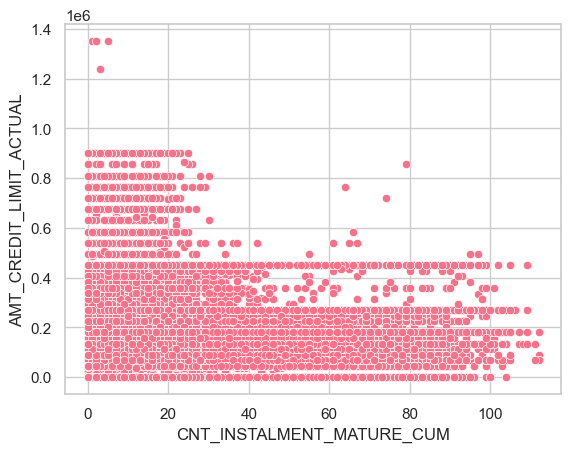

In [66]:
sns.scatterplot(data=credit_card_balance.sample(100000, random_state=42),
                x='CNT_INSTALMENT_MATURE_CUM',
                y='AMT_CREDIT_LIMIT_ACTUAL'
                )
plt.show()

In [67]:
sns.scatterplot(data=credit_card_balance.sample(100000, random_state=42),
                x='CNT_INSTALMENT_MATURE_CUM',
                y='AMT_BALANCE'
                )
plt.show()

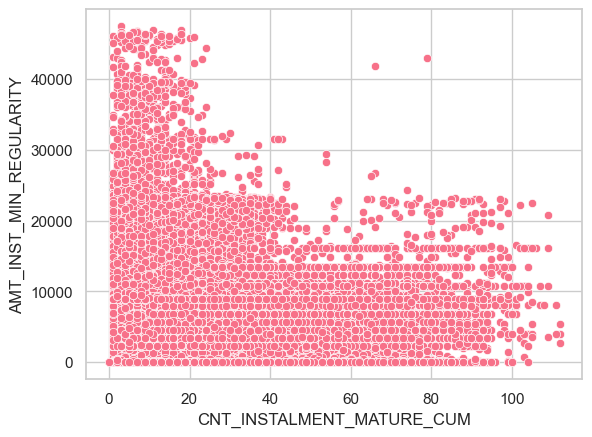

In [68]:
sns.scatterplot(data=credit_card_balance.sample(100000, random_state=42),
                x='CNT_INSTALMENT_MATURE_CUM',
                y='AMT_INST_MIN_REGULARITY'
                )
plt.show()

## Feature Engineering
Adding features for various ratios on limits, utilization, cash drawings, pprinciple rates. Also, FLAG_ZERO_AMT_BALANCE and FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL depict periods of Zero balance or Zero limit.

In [69]:
credit_card_balance['CARD_ACTIVITY'] = credit_card_balance['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_card_activity)
credit_card_balance['RISK_PROFILE'] = credit_card_balance['NAME_CONTRACT_STATUS'].apply(help_tool.categorize_risk_profile)

credit_card_balance.drop(columns='NAME_CONTRACT_STATUS', inplace=True)

In [70]:
credit_card_balance['FLAG_ZERO_AMT_BALANCE'] = np.where(credit_card_balance['AMT_BALANCE'] == 0, 1, 0)
credit_card_balance['FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL'] = np.where(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] == 0, 1, 0)

In [71]:
credit_card_balance[[
    'RATE_UTILIZATION_LIMIT', 'RATE_INSTALMENT_BALANCE', 'RATE_INST_MIN', 'RATIO_DPD', 
    'RATE_DRAWINGS_CURRENT', 'RATE_DRAWINGS_ATM_CURRENT', 'RATE_DRAWINGS_OTHER_CURRENT', 'RATE_DRAWINGS_POS_CURRENT',
    'RATE_RECEIVABLE', 'RATE_RECEIVABLE_PRINCIPAL', 'RATE_PAYMENT_CURRENT', 'RATE_RECEIVABLE_VS_PAYMENT'
                     ]] = duckdb.query("""
            SELECT 
            
             (AMT_CREDIT_LIMIT_ACTUAL / AMT_BALANCE) AS RATE_UTILIZATION_LIMIT,

             (CNT_INSTALMENT_MATURE_CUM / AMT_BALANCE) AS RATE_INSTALMENT_BALANCE,
             (CNT_INSTALMENT_MATURE_CUM / AMT_INST_MIN_REGULARITY) AS RATE_INST_MIN,

             (SK_DPD / SK_DPD_DEF) AS RATIO_DPD,

             (AMT_DRAWINGS_CURRENT / CNT_DRAWINGS_CURRENT) AS RATE_DRAWINGS_CURRENT,
             (AMT_DRAWINGS_ATM_CURRENT / CNT_DRAWINGS_ATM_CURRENT) AS RATE_DRAWINGS_ATM_CURRENT,
             (AMT_DRAWINGS_OTHER_CURRENT / CNT_DRAWINGS_OTHER_CURRENT) AS RATE_DRAWINGS_OTHER_CURRENT,
             (AMT_DRAWINGS_POS_CURRENT / CNT_DRAWINGS_POS_CURRENT) AS RATE_DRAWINGS_POS_CURRENT,

             (AMT_TOTAL_RECEIVABLE / AMT_RECIVABLE) AS RATE_RECEIVABLE,
             (AMT_RECEIVABLE_PRINCIPAL / AMT_RECIVABLE) AS RATE_RECEIVABLE_PRINCIPAL,

             (AMT_PAYMENT_TOTAL_CURRENT / AMT_PAYMENT_CURRENT) AS RATE_PAYMENT_CURRENT,

             (AMT_PAYMENT_CURRENT / AMT_RECIVABLE) AS RATE_RECEIVABLE_VS_PAYMENT       

            FROM credit_card_balance

""").to_df()

### Aggregated features with FeatureTools

In [72]:
credit_card_balance_feature_matrix = help_model.aggregated_features(credit_card_balance.drop(columns=['MONTHS_BALANCE']), 'SK_ID_PREV')
credit_card_balance_feature_matrix.shape

(104307, 154)

Adding aggregated duration

In [75]:
credit_card_balance_feature_matrix = duckdb.query("""  
  SELECT A.*, B.Duration
  FROM credit_card_balance_feature_matrix A 
  LEFT JOIN (
    SELECT SK_ID_PREV, MAX(MONTHS_BALANCE) - MIN(MONTHS_BALANCE) AS Duration
    FROM credit_card_balance
    GROUP BY SK_ID_PREV
    ) B ON A.SK_ID_PREV = B.SK_ID_PREV
  """).to_df()

In [76]:
credit_card_balance_feature_matrix.to_csv(r'Archive\home-credit-default-risk\credit_card_balance_feature_matrix.csv')

## Selecting features
8% of target is positive

In [77]:
app_credit_card_balance_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM credit_card_balance_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

app_credit_card_balance_feature_matrix['TARGET'].value_counts() / app_credit_card_balance_feature_matrix['TARGET'].count() * 100

TARGET
0    91.320953
1     8.679047
Name: count, dtype: float64

'MIN(df.SK_DPD)' and 'MIN(df.SK_DPD_DEF)' had dropped variance after joining on application_train set, which means these features could be useful on test set, but also they have low variance as is. Their contribution would probably not be great.

In [78]:
credit_card_balance_feature_matrix[['MIN(df.SK_DPD)', 'MIN(df.SK_DPD_DEF)']].var()

MIN(df.SK_DPD)        2.011025
MIN(df.SK_DPD_DEF)    2.011025
dtype: float64

In [79]:
app_credit_card_balance_feature_matrix[['MIN(df.SK_DPD)', 'MIN(df.SK_DPD_DEF)']].var()

MIN(df.SK_DPD)        0.0
MIN(df.SK_DPD_DEF)    0.0
dtype: float64

In [80]:
app_credit_card_balance_feature_matrix.drop(
        columns= ['MIN(df.SK_DPD)', 'MIN(df.SK_DPD_DEF)'], 
        inplace = True
        )

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

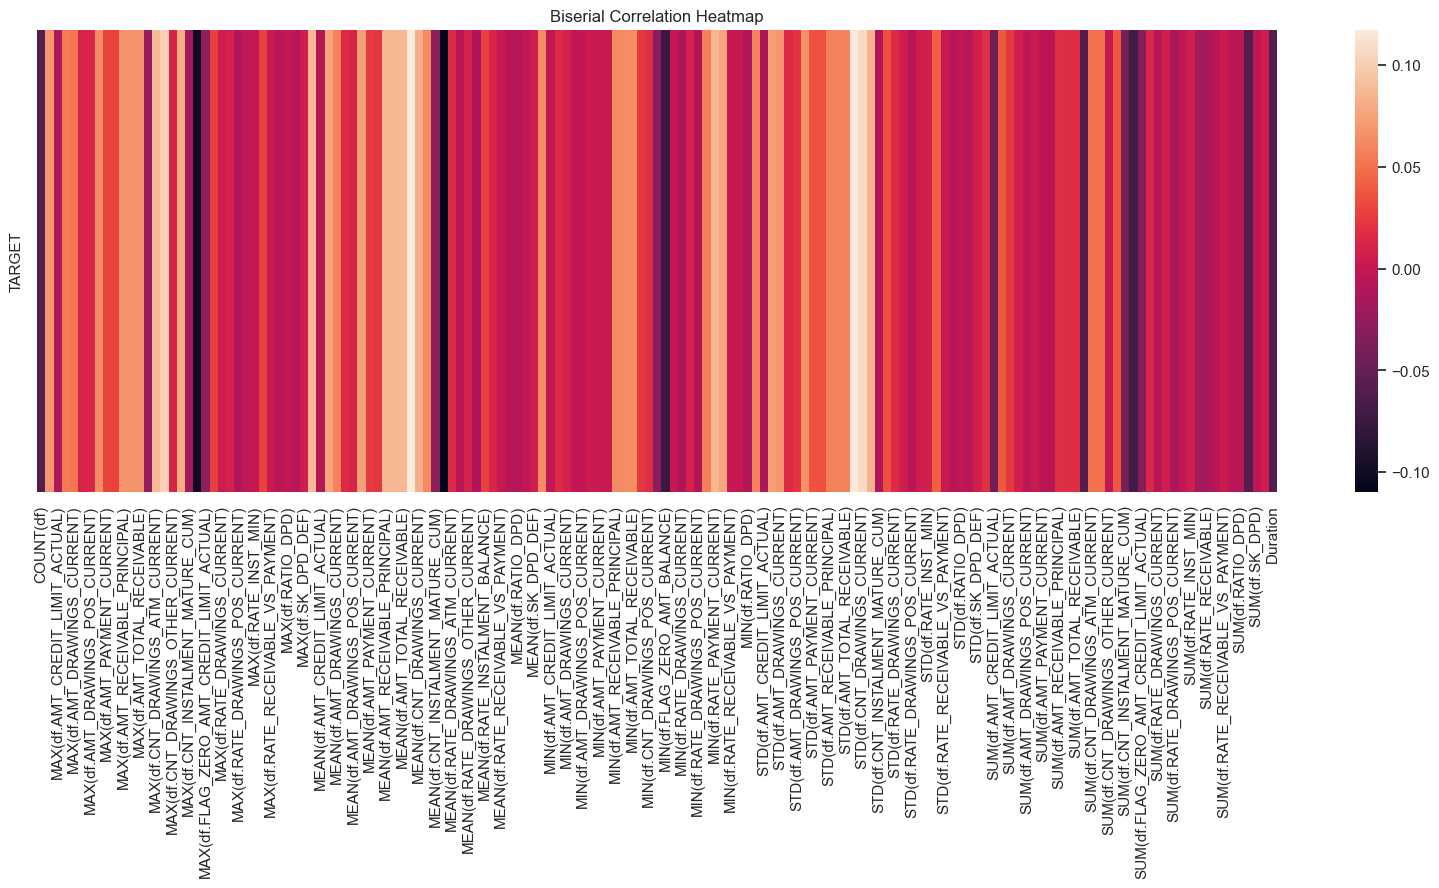

In [81]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_credit_card_balance_feature_matrix.fillna(-1), app_credit_card_balance_feature_matrix.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

### Light XGB

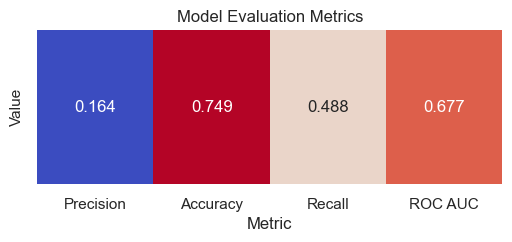

In [82]:
feature_importance_credit_card = help_model.model_feature_importance_target(app_credit_card_balance_feature_matrix)

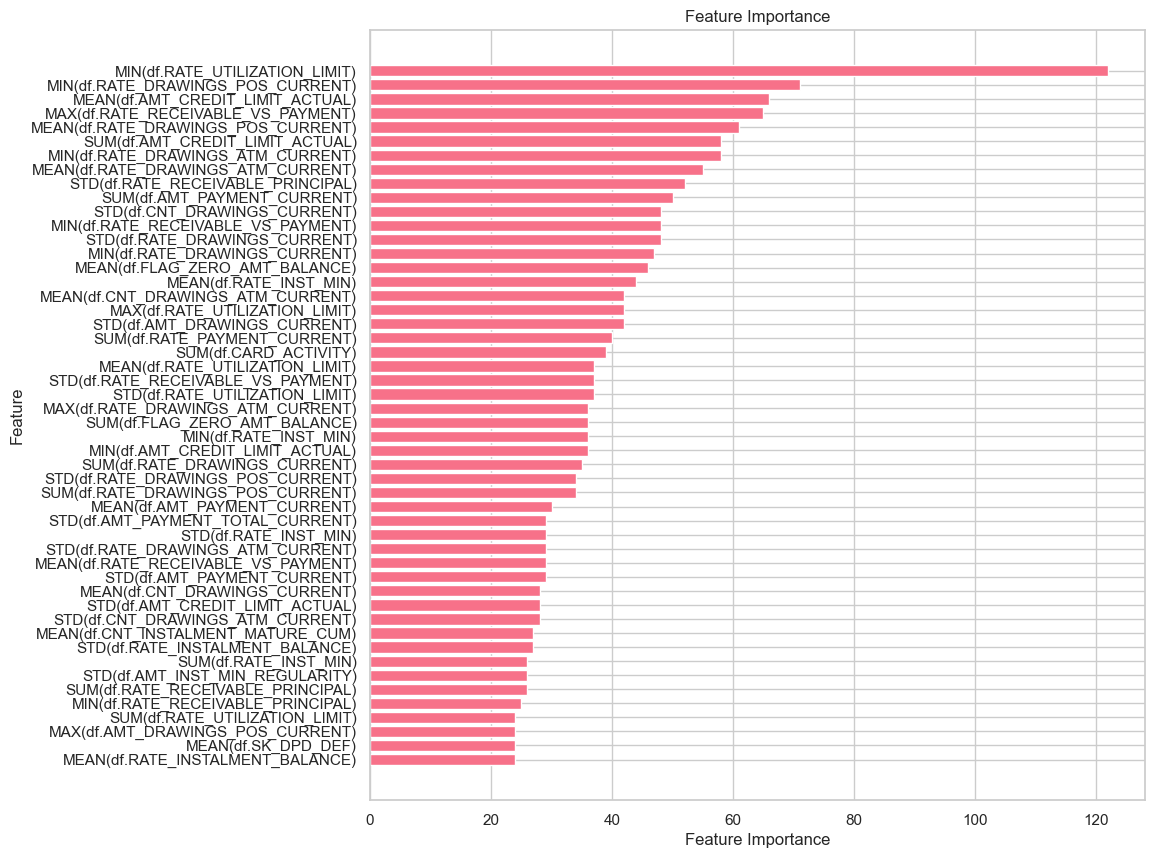

In [83]:
help_model.plot_feature_importance(feature_importance_credit_card.head(50))

### 6 top features are selected
No top 6 features are correlated among each other.

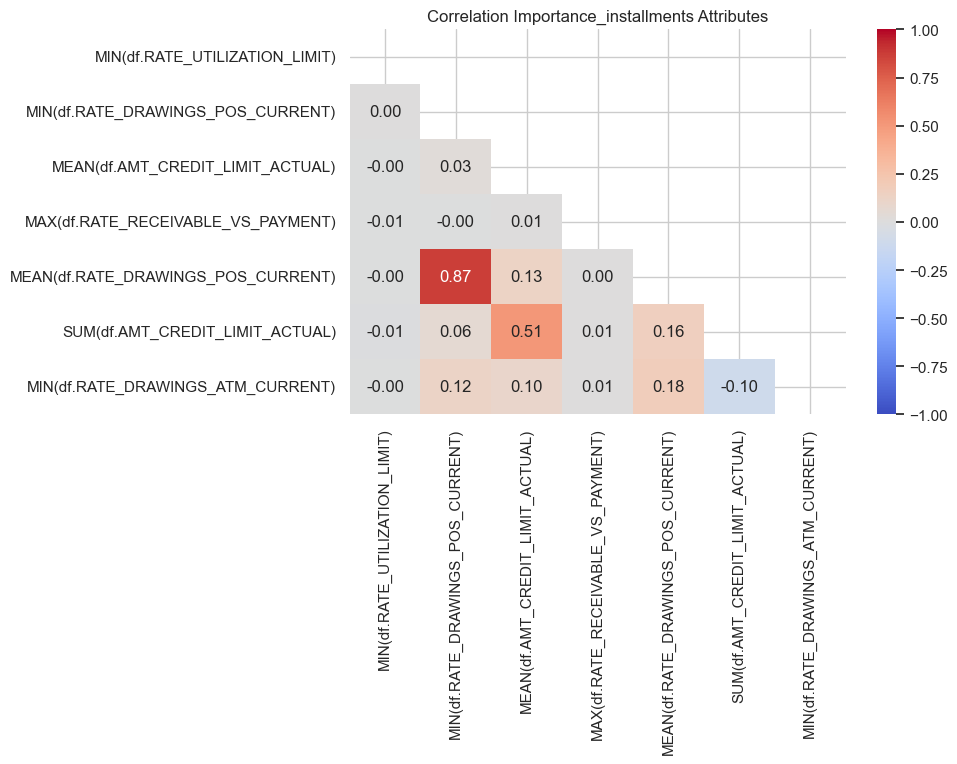

In [84]:
help_visuals.heatmap(app_credit_card_balance_feature_matrix[feature_importance_credit_card['feature'].head(7).to_list()], 'importance_installments', 'pearson')

### Multicollinearity
SUM(df.AMT_CREDIT_LIMIT_ACTUAL) has VIF between 5-7, but is deemed acceptable.

In [85]:
credit_card_selected_features = feature_importance_credit_card['feature'].head(7).to_list()
help_stats.vif(app_credit_card_balance_feature_matrix[credit_card_selected_features].fillna(-1))

variables       VIF
0      MIN(df.RATE_UTILIZATION_LIMIT)  1.000291
1   MIN(df.RATE_DRAWINGS_POS_CURRENT)  4.551419
2    MEAN(df.AMT_CREDIT_LIMIT_ACTUAL)  2.661211
3  MAX(df.RATE_RECEIVABLE_VS_PAYMENT)  1.000440
4  MEAN(df.RATE_DRAWINGS_POS_CURRENT)  4.906903
5     SUM(df.AMT_CREDIT_LIMIT_ACTUAL)  2.587596
6   MIN(df.RATE_DRAWINGS_ATM_CURRENT)  1.185537

MIN(df.RATE_UTILIZATION_LIMIT)


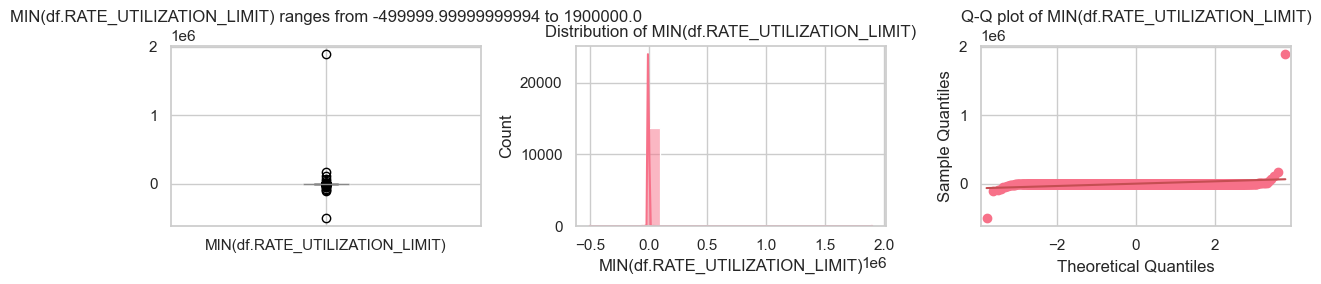

MIN(df.RATE_DRAWINGS_POS_CURRENT)


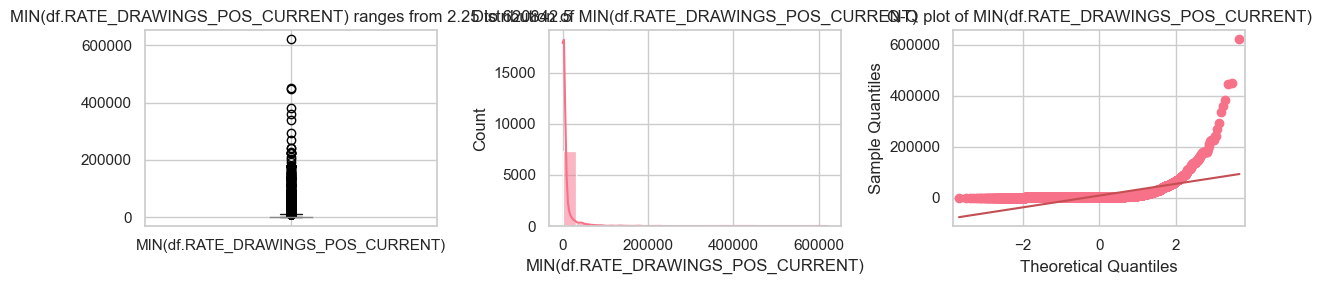

MEAN(df.AMT_CREDIT_LIMIT_ACTUAL)


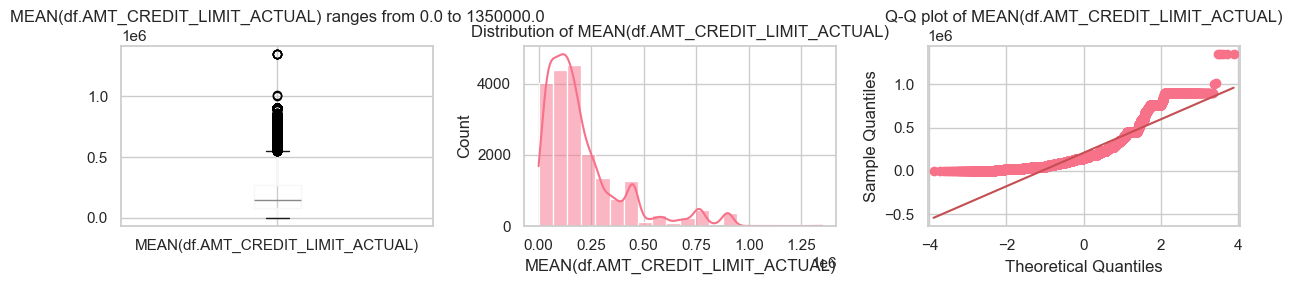

MAX(df.RATE_RECEIVABLE_VS_PAYMENT)


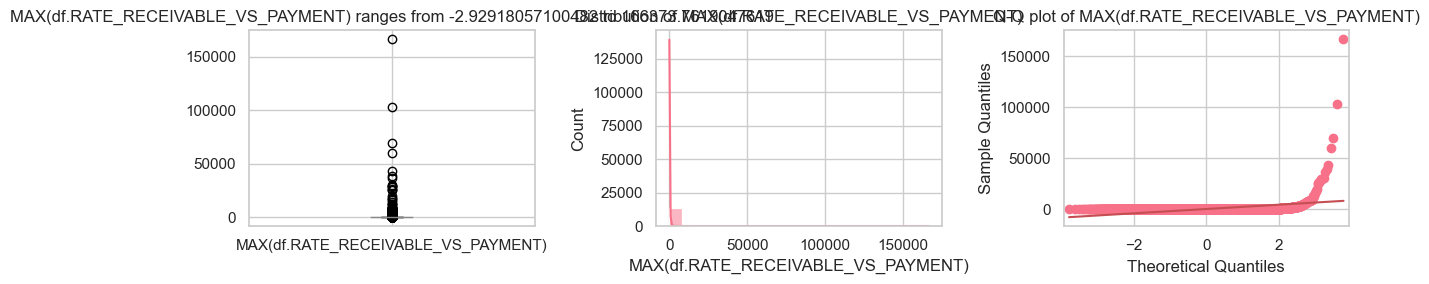

MEAN(df.RATE_DRAWINGS_POS_CURRENT)


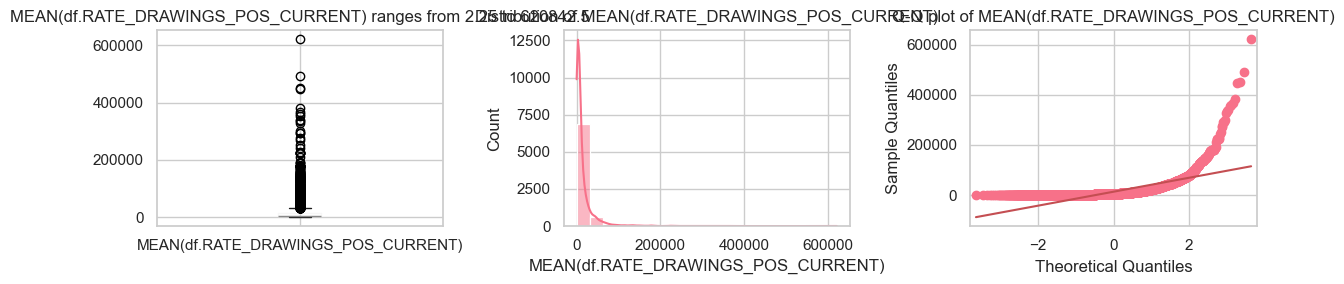

SUM(df.AMT_CREDIT_LIMIT_ACTUAL)


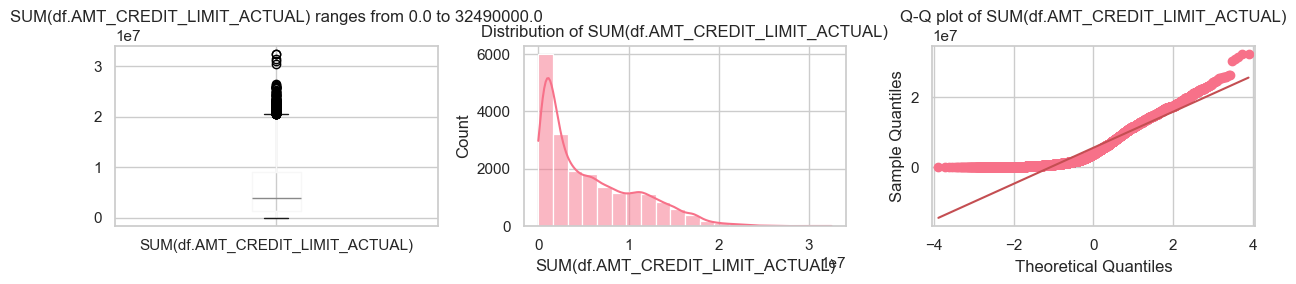

MIN(df.RATE_DRAWINGS_ATM_CURRENT)


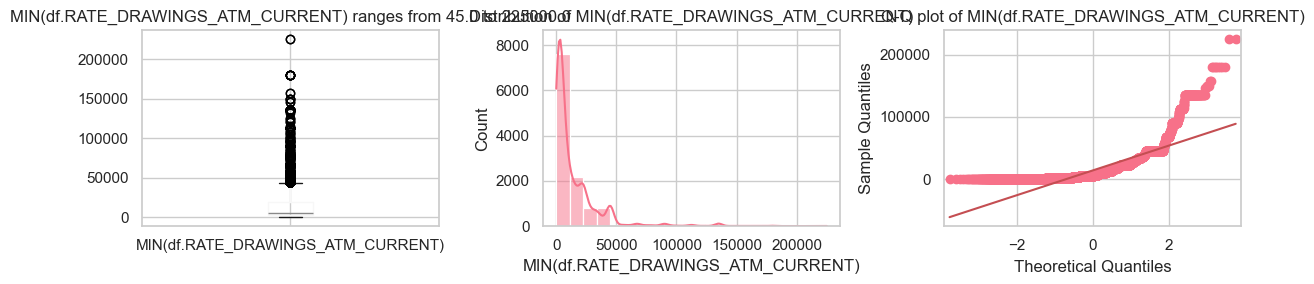

In [86]:
help_visuals.distribution_check(app_credit_card_balance_feature_matrix[credit_card_selected_features].sample(20000, random_state=42))

## Clustering with K means

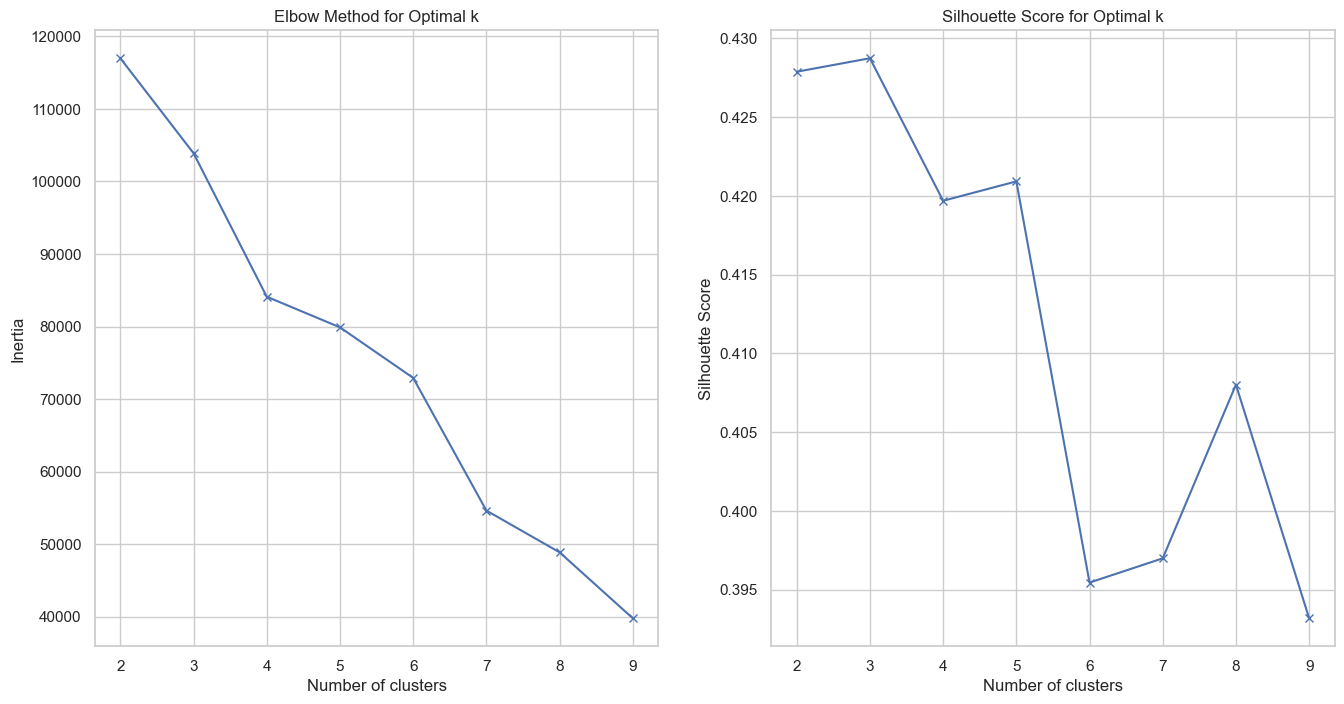

In [87]:
help_model.clustering_k_means_test(app_credit_card_balance_feature_matrix[credit_card_selected_features].sample(20000, random_state=42).fillna(0))

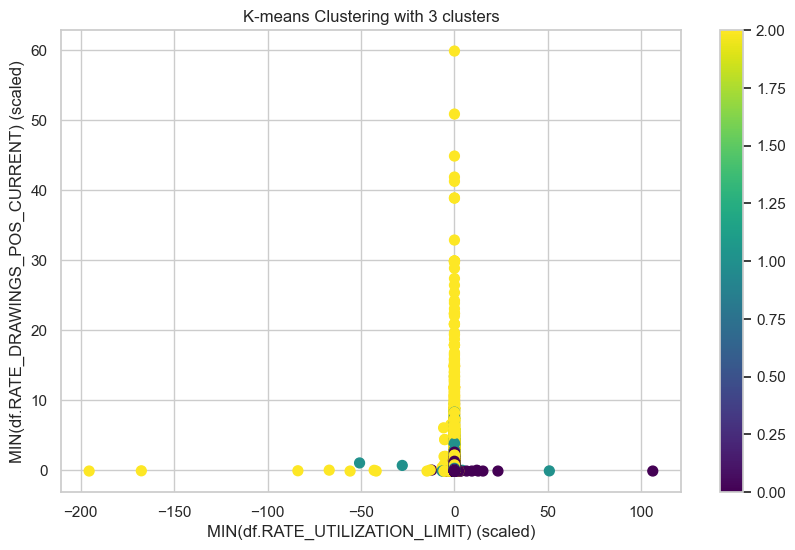

In [88]:
credit_card_balance_feature_matrix['Cluster_credit_card'] = help_model.clustering_k_means(credit_card_balance_feature_matrix[credit_card_selected_features].fillna(0), 3)

In [89]:
credit_card_balance_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM credit_card_balance_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

Clusters have similar distribution to TARGET and the whole dataset.

In [90]:
credit_card_balance_feature_matrix[['Cluster_credit_card', 'TARGET']].value_counts().sort_index() / credit_card_balance_feature_matrix['Cluster_credit_card'].value_counts().sort_index() * 100

Cluster_credit_card  TARGET
0                    0         90.602540
                     1          9.397460
1                    0         92.248424
                     1          7.751576
2                    0         92.862443
                     1          7.137557
Name: count, dtype: float64

## Exporting

In [91]:
sorted_credit_card_balance_feature_matrix = credit_card_balance_feature_matrix[['SK_ID_PREV', 'SK_ID_CURR', 'Cluster_credit_card'] + credit_card_selected_features]
sorted_credit_card_balance_feature_matrix.to_csv(r'Archive\home-credit-default-risk\sorted_credit_card_balance_feature_matrix.csv')